# 1. Transformer와 비교해 변경이 필요한 부분을 서술한다.

## Text & position Embed
+ 기존 Transformer에 outputEedding과 PositionalEncoding -> Text & positionEmbed로 변경

## CrossAttention 제거
+ Transformer와 달리 Encoder가 없기 때문에 Encoder를 필요로 하는 Decoder의 층 제거

## Decoder의 층
+ Encoder 6개, Decoder 6개 (Transformer) -> Decoder 12개 (GPT1)

## 목표
+ Transformer의 목표는 기계번역 seq2seq -> GPT1 finetuning단계에 task-specific을 얹음


In [202]:
import tensorflow as tf

# 2. 모델의 입력 형태에 맞게 전처리를 수행한다.

In [203]:
import os
import pandas as pd
path_to_dataset = "data/ChatbotData.csv"
data = pd.read_csv(path_to_dataset)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11823 entries, 0 to 11822
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       11823 non-null  object
 1   A       11823 non-null  object
 2   label   11823 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 277.2+ KB


In [204]:
train_data = data['Q']


### Q 데이터만을 사용한다.

In [205]:
train_data

0                         12시 땡!
1                    1지망 학교 떨어졌어
2                   3박4일 놀러가고 싶다
3                3박4일 정도 놀러가고 싶다
4                        PPL 심하네
                  ...           
11818             훔쳐보는 것도 눈치 보임.
11819             훔쳐보는 것도 눈치 보임.
11820                흑기사 해주는 짝남.
11821    힘든 연애 좋은 연애라는게 무슨 차이일까?
11822                 힘들어서 결혼할까봐
Name: Q, Length: 11823, dtype: object

In [206]:
import re

def preprocess_data(train_data):
    text_data = []
    for sentence in train_data:
        # 구두점에 대해서 띄어쓰기
        # ex) 12시 땡! -> 12시 땡 !
        sentence = sentence.replace('.',"")
        sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
        sentence = sentence.strip()
        text_data.append(sentence)

    return text_data

text_data = preprocess_data(train_data)

In [207]:
text_data

['12시 땡 !',
 '1지망 학교 떨어졌어',
 '3박4일 놀러가고 싶다',
 '3박4일 정도 놀러가고 싶다',
 'PPL 심하네',
 'SD카드 망가졌어',
 'SD카드 안돼',
 'SNS 맞팔 왜 안하지ㅠㅠ',
 'SNS 시간낭비인 거 아는데 매일 하는 중',
 'SNS 시간낭비인데 자꾸 보게됨',
 'SNS보면 나만 빼고 다 행복해보여',
 '가끔 궁금해',
 '가끔 뭐하는지 궁금해',
 '가끔은 혼자인게 좋다',
 '가난한 자의 설움',
 '가만 있어도 땀난다',
 '가상화폐 쫄딱 망함',
 '가스불 켜고 나갔어',
 '가스불 켜놓고 나온거 같아',
 '가스비 너무 많이 나왔다',
 '가스비 비싼데 감기 걸리겠어',
 '가스비 장난 아님',
 '가장 확실한 건 뭘까 ?',
 '가족 여행 가기로 했어',
 '가족 여행 고고',
 '가족 여행 어디로 가지 ?',
 '가족 있어 ?',
 '가족관계 알려 줘',
 '가족끼리 여행간다',
 '가족들 보고 싶어',
 '가족들이랑 서먹해',
 '가족들이랑 서먹해졌어',
 '가족들이랑 어디 가지 ?',
 '가족들이랑 여행 갈거야',
 '가족여행 가야지',
 '가족이 누구야 ?',
 '가족이랑 여행 가려고',
 '가족한테 스트레스 풀었어',
 '가출할까 ?',
 '가출해도 갈 데가 없어',
 '간만에 떨리니까 좋더라',
 '간만에 쇼핑 중',
 '간만에 휴식 중',
 '간식 뭐 먹을까',
 '간식 추천',
 '간장치킨 시켜야지',
 '간접흡연 싫어',
 '갈까 말까 고민 돼',
 '갈까 말까 ?',
 '감 말랭이 먹고 싶다',
 '감 말랭이 먹어야지',
 '감기 같애',
 '감기 걸린 것 같아',
 '감기 기운이 있어',
 '감기 들 거 같애',
 '감기가 오려나',
 '감기약이 없어',
 '감기인거 같애',
 '감미로운 목소리 좋아',
 '감정이 쓰레기통처럼 엉망진창이야',
 '감정컨트롤을 못하겠어',
 '감정컨트롤이 안돼',
 '감히 나를 무시하는 애가 있어',
 '갑자기 나쁜 생각이 막 들더라',
 '갑자기 눈

In [208]:
import tensorflow_datasets as tfds

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(text_data, target_vocab_size=2**13)

In [209]:
tokenizer

<SubwordTextEncoder vocab_size=5970>

In [210]:
SOS, EOS = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [211]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [5970]
END_TOKEN의 번호 : [5971]


In [212]:
VOCAB_SIZE = tokenizer.vocab_size + 2

In [213]:
MAX_LENGTH = 40

### 토큰나이저 필터도 하나로 줄임

In [214]:
def tokenize_and_filter(inputs):
      tokenized_inputs = []

      for sentence in inputs:
        sentence = SOS + tokenizer.encode(sentence) + EOS
        tokenized_inputs.append(sentence)

      # 패딩
      tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
          tokenized_inputs, maxlen=MAX_LENGTH, padding='post')

      return tokenized_inputs

In [215]:
text_data = tokenize_and_filter(text_data)

In [216]:
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(text_data.shape))
print('필터링 후의 답변 샘플 개수: {}'.format(len(text_data)))

단어장의 크기 : 5972
필터링 후의 질문 샘플 개수: (11823, 40)
필터링 후의 답변 샘플 개수: 11823


### 들어가는 데이터는 하나의 1D데이터이기 때문에 디코더부분 단순화

In [217]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

dataset = tf.data.Dataset.from_tensor_slices(text_data)

dataset = dataset.map(
    lambda seq: (
        seq[:-1],
        seq[1:]
    )
)

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
data = dataset.prefetch(tf.data.experimental.AUTOTUNE)

# 모델의 입력 블럭을 GPT 논문에 기반하여 수정한다.

### Text & position Embed 구성

In [218]:
class TextPositionEmbeding(tf.keras.layers.Layer):  
    def __init__(self, vocab_size, max_position, d_model):
        super(TextPositionEmbeding, self).__init__()
        # UWe 입력 토큰 X 토큰 임베딩 행렬
        self.token_emb = tf.keras.layers.Embedding(vocab_size, d_model)
        # Wp 포지션임베딩 행렬
        self.pos_emb = tf.keras.layers.Embedding(max_position, d_model)
        
    # angle 제거
    
    def call(self, inputs):
        x = self.token_emb(inputs)
        positions = tf.range(tf.shape(inputs)[1])
        p = self.pos_emb(positions)
        # x와 p를 더한 값을 리턴
        return x + p[tf.newaxis, ...]

In [219]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [220]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

In [221]:
def scaled_dot_product_attention(query, key, value, mask):
    matmul_qk = tf.matmul(query, key, transpose_b=True)
    
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)
    
    if mask is not None:
        logits += (mask * -1e9)
        
    attention_weights = tf.nn.softmax(logits, axis=1)
    
    output = tf.matmul(attention_weights, value)
    
    return output

In [222]:
class MultiHeadAttention(tf.keras.layers.Layer):
    
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % self.num_heads == 0
        
        self.depth = d_model // self.num_heads
        
        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        
        self.dense = tf.keras.layers.Dense(units=d_model)
        
    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0,2,1,3])
    
    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
            
        batch_size = tf.shape(key)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)# [[YOUR CODE]]
        key = self.key_dense(key)# [[YOUR CODE]]
        value = self.value_dense(value)# [[YOUR CODE]]

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query,batch_size)# [[YOUR CODE]]
        key = self.split_heads(key,batch_size)# [[YOUR CODE]]
        value = self.split_heads(value,batch_size)# [[YOUR CODE]]

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                          (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs

### Decoder Layer 구성

In [223]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
      inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
      look_ahead_mask = tf.keras.Input(
          shape=(1, None, None), name="look_ahead_mask")
      padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

      # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
      attention1 = MultiHeadAttention(
          d_model, num_heads, name="attention_1")(inputs={
              'query': inputs,
              'key': inputs,
              'value': inputs,
              'mask': look_ahead_mask
          })

      # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
      attention1 = tf.keras.layers.LayerNormalization(
          epsilon=1e-6)(attention1 + inputs)

      # 두 번째 서브 레이어 제거

      # 세 번째 서브 레이어 : 2개의 완전연결층
      outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention1)
      outputs = tf.keras.layers.Dense(units=d_model)(outputs)

      # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
      outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
      outputs = tf.keras.layers.LayerNormalization(
          epsilon=1e-6)(outputs)

      return tf.keras.Model(
          inputs=[inputs,look_ahead_mask, padding_mask],
          outputs=outputs,
          name=name)

In [224]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
      inputs = tf.keras.Input(shape=(None,), name='inputs')
      look_ahead_mask = tf.keras.Input(
          shape=(1, None, None), name='look_ahead_mask')

      # 패딩 마스크
      padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
        
      # 기존 임베딩 레이어와 포지셔널 인코딩을 Text&Position임베딩으로 수정
      embeddings = TextPositionEmbeding(vocab_size,MAX_LENGTH ,d_model)(inputs)

      # Dropout이라는 훈련을 돕는 테크닉을 수행
      outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

      for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, look_ahead_mask, padding_mask])

      return tf.keras.Model(
          inputs=[inputs, look_ahead_mask, padding_mask],
          outputs=outputs,
          name=name)


### GPT1 구성

In [225]:
def gpt1(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="gpt1"):
      inputs = tf.keras.Input(shape=(None,), name="inputs")

      # 디코더 패딩 마스크
      padding_mask = tf.keras.layers.Lambda(
          create_padding_mask, output_shape=(1, 1, None),
          name='padding_mask')(inputs)

      # 디코더 어텐션 마스크
      look_ahead_mask = tf.keras.layers.Lambda(
          create_look_ahead_mask,
          output_shape=(1, None, None),
          name='look_ahead_mask')(inputs)

      # 디코더
      outputs = decoder(
          vocab_size=vocab_size,
          num_layers=num_layers,
          units=units,
          d_model=d_model,
          num_heads=num_heads,
          dropout=dropout,
      )(inputs=[inputs, look_ahead_mask, padding_mask])

      # 완전연결층
      outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(outputs)

      return tf.keras.Model(inputs=[inputs], outputs=outputs, name=name)

# GPT 모델을 정상적으로 구성

In [226]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 4 # 디코더 갯수 기존의 두 배
D_MODEL = 512 # 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = gpt1(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "gpt1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
look_ahead_mask (Lambda)        (None, 1, None, None 0           inputs[0][0]                     
__________________________________________________________________________________________________
padding_mask (Lambda)           (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
decoder (Functional)            (None, None, 512)    9390080     inputs[0][0]                     
                                                                 look_ahead_mask[0][0]         

In [227]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

In [228]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

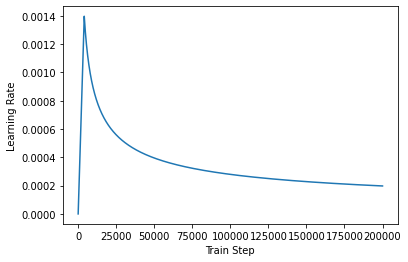

In [229]:
import matplotlib.pyplot as plt
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [230]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [231]:
EPOCHS = 20
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
185/185 [==============================] - 20s 84ms/step - loss: 1.2816 - accuracy: 0.0209
Epoch 2/20
185/185 [==============================] - 15s 82ms/step - loss: 1.1432 - accuracy: 0.0257
Epoch 3/20
185/185 [==============================] - 14s 77ms/step - loss: 1.1247 - accuracy: 0.0256
Epoch 4/20
185/185 [==============================] - 14s 76ms/step - loss: 1.1163 - accuracy: 0.0256
Epoch 5/20
185/185 [==============================] - 14s 77ms/step - loss: 1.1212 - accuracy: 0.0252
Epoch 6/20
185/185 [==============================] - 15s 80ms/step - loss: 1.1112 - accuracy: 0.0259
Epoch 7/20
185/185 [==============================] - 15s 81ms/step - loss: 1.1025 - accuracy: 0.0262
Epoch 8/20
185/185 [==============================] - 14s 78ms/step - loss: 1.1193 - accuracy: 0.0258
Epoch 9/20
185/185 [==============================] - 14s 77ms/step - loss: 1.1252 - accuracy: 0.0256
Epoch 10/20
185/185 [==============================] - 14s 78ms/step - loss: 1.122

In [232]:
def preprocess_sentence(sentence):
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = sentence.strip()
  return sentence

In [241]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)


  sentence = tf.expand_dims(
      SOS + tokenizer.encode(sentence) + EOS, axis=0)


  output_sequence = tf.expand_dims(SOS, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):

    predictions = model(inputs=[output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
   # if tf.equal(predicted_id, EOS[0]):
    #  break


    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

In [242]:
def sentence_generation(sentence):
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence

# 입력에 따른 출력을 생성

In [243]:
sentence_generation('어떻게 지내?')

입력 : 어떻게 지내?
출력 : 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 


'남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 '

In [244]:
sentence_generation('뭐해?')

입력 : 뭐해?
출력 : 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 


'남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 '

In [245]:
sentence_generation('아무대답이나 해라 !!!')

입력 : 아무대답이나 해라 !!!
출력 : 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 


'남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 남자친구가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 내가 '

# 회고
에폭을 변경할 때마다 더욱 풍성한 대답이 나오는걸로 보아 제대로 작동된다고는 추측되나 확신이 없다.
쫌 더 연구를 해보아야겠다...